<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-KMeans" data-toc-modified-id="1.-KMeans-1">1. KMeans</a></span><ul class="toc-item"><li><span><a href="#1.1-K-Means-算法" data-toc-modified-id="1.1-K-Means-算法-1.1">1.1 K-Means 算法</a></span></li><li><span><a href="#1.2-中心点初始化方法（Centroid-initialization-methods）" data-toc-modified-id="1.2-中心点初始化方法（Centroid-initialization-methods）-1.2">1.2 中心点初始化方法（Centroid initialization methods）</a></span><ul class="toc-item"><li><span><a href="#1.2.1-事先知道-centroids-的大概位置" data-toc-modified-id="1.2.1-事先知道-centroids-的大概位置-1.2.1">1.2.1 事先知道 centroids 的大概位置</a></span></li><li><span><a href="#1.2.2-用不同的随机初始化来多次运行算法" data-toc-modified-id="1.2.2-用不同的随机初始化来多次运行算法-1.2.2">1.2.2 用不同的随机初始化来多次运行算法</a></span></li><li><span><a href="#1.2.3-K-Means++" data-toc-modified-id="1.2.3-K-Means++-1.2.3">1.2.3 K-Means++</a></span></li></ul></li><li><span><a href="#1.3-加速的-K-Means-和-Mini-Batch-K-Means" data-toc-modified-id="1.3-加速的-K-Means-和-Mini-Batch-K-Means-1.3">1.3 加速的 K-Means 和 Mini-Batch K-Means</a></span><ul class="toc-item"><li><span><a href="#1.3.1-Accelerated-K-Means" data-toc-modified-id="1.3.1-Accelerated-K-Means-1.3.1">1.3.1 Accelerated K-Means</a></span></li><li><span><a href="#1.3.2-Mini-Batch-K-Means" data-toc-modified-id="1.3.2-Mini-Batch-K-Means-1.3.2">1.3.2 Mini-Batch K-Means</a></span></li></ul></li><li><span><a href="#1.4-寻找最佳的聚类数" data-toc-modified-id="1.4-寻找最佳的聚类数-1.4">1.4 寻找最佳的聚类数</a></span></li><li><span><a href="#1.5-K-Means-的局限性" data-toc-modified-id="1.5-K-Means-的局限性-1.5">1.5 K-Means 的局限性</a></span></li></ul></li><li><span><a href="#2.-使用聚类进行图像分割" data-toc-modified-id="2.-使用聚类进行图像分割-2">2. 使用聚类进行图像分割</a></span></li><li><span><a href="#3.-使用聚类进行数据预处理（Using-clustering-for-Preprocessing）" data-toc-modified-id="3.-使用聚类进行数据预处理（Using-clustering-for-Preprocessing）-3">3. 使用聚类进行数据预处理（Using clustering for Preprocessing）</a></span></li><li><span><a href="#4.-使用聚类进行半监督学习" data-toc-modified-id="4.-使用聚类进行半监督学习-4">4. 使用聚类进行半监督学习</a></span></li><li><span><a href="#5.-DBCSAN" data-toc-modified-id="5.-DBCSAN-5">5. DBCSAN</a></span></li><li><span><a href="#6.-其他聚类算法" data-toc-modified-id="6.-其他聚类算法-6">6. 其他聚类算法</a></span></li></ul></div>

In [1]:
# Common imports
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn


%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

np.random.seed(42)
# Display all the estimator's all parameters when print estimator
# True: only display the non-default values
sklearn.set_config(print_changed_only=False)
# warnings.filterwarnings(action='ignore', message="^internal gelsd")

print('Version of Python:', sys.version)
print('Version of pandas:', pd.__version__)
print('Version of Scikit-Learn:', sklearn.__version__)

Version of Python: 3.6.10 |Anaconda, Inc.| (default, May  8 2020, 02:54:21) 
[GCC 7.3.0]
Version of pandas: 1.1.5
Version of Scikit-Learn: 0.24.1


**聚类没有统一的定义（universal definition），它实际上取决于上下文（context），并且不同的算法会得到不同类型的簇（cluster）。**

- 一些算法会寻找以特定点（a particular point）（称之为 **centroid**）为中心的样本；


- 一些算法会寻找样本密集（densely packed instances）的连续区域（continuous regions）——这些 clusters 可以是任何形状；


- 一些算法是层次型的（hierarchical），寻找 clusters of clusters


- ...

聚类应用广泛：

- **<font color='crimson'>客户分群（Customer Segmentation）</font>**

可以根据客户的购买记录和在网站上的活动记录对客户聚类。这对于了解是谁以及他们需要什么很有用，因此可以针对每个客群（each segment）使用不同的产品和营销活动（marketing campaigns）。


- **<font color='crimson'>数据分析（Data Analysis）</font>**

在分析新数据集时，运行聚类算法，然后单独地分析每一个 cluster。


- **<font color='crimson'>降维（Dimensionality Reduction）</font>**

数据聚类后，通常可以衡量每个样本于每个 cluster 的亲密度（affinity）——是用于衡量一个样本和一个 cluster 合适程度的任何指标。每个样本的特征向量 $\pmb{x}$ 可以替换为与 cluster 的亲密度向量。如果有 k 个 clusters 的话，那么这个向量就是 k 维的。这个向量的维度通常比原始特征向量的维度要低得多，但其保留了足够多的信息以进行下一步处理。

> **<font color='blue'>Affinity</font>** is any measure of how well an instance fits into a cluster.


- **<font color='crimson'>异常检测（Anomaly Detection, or outlier Detection）</font>**

与所有的 cluster 的亲密度（affinity）都很低的样本都可能是异常点（anomaly）。比如，如果对网站的用户基于他们的行为进行了聚类，那么可以检测异常行为的客户，如每秒的请求数量异常。异常检测在生产线中检测缺陷品（defects）和欺诈检测中非常有用。


- **<font color='crimson'>半监督学习（Semi-supervised Learning）</font>**

如果只有很少的标签样本，那么可以使用聚类算法并将标签传播（propagate）给同一 cluster 中的所有样本。这种技术可以大大增加标签的数量。


- **<font color='crimson'>搜索引擎（Search Engines）</font>**

在搜索与参考图片（reference image）相似的图片时，首先要对数据库中的所有图像应用聚类算法，相似的图片会在同一个 cluster 中。然后，当用户提供参考图片（reference image）时，需要做的就是使用训练好的算法找到该图片所属的 cluster，然后返回该 cluster 中的所有图片。


- **<font color='crimson'>图片分割（Image Segmentation）</font>**

通过根据像素（pixel）的颜色对像素进行聚类，然后使用 cluster 的平均颜色代替每个像素的颜色，这样可以显著图片中不同颜色的数量。图片分割用于物体检测（object detection）和跟踪系统（tracking system）中，因为可以轻松地检测出每个物体（object）的轮廓（contour）。

# 1. KMeans

In [2]:
from sklearn.datasets import make_blobs


blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)
X.shape, y.shape

((2000, 2), (2000,))

In [3]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14, rotation=0)

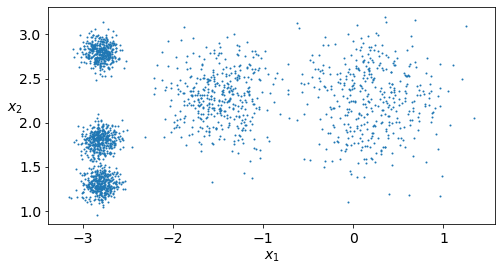

In [4]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

K-Means 是一种简单的算法，能够快速、高效地对此类数据集进行聚类，通常只需要通过几次迭代（iterations）。

由 Bell Labs 的 Stuart Lloyd 在 1957 年提出，用于脉冲编码调制（pulse-code modulation），但直到 [1982](https://homl.info/36) 年才对外发布。在 1965 年，Edward W. Forgy 发布了同样的算法，所以 K-Means 算法有时被称为 **<font color='blue'>Lloyd–Forgy</font>**。

基于上面的数据集训练一个 K-Means 聚类器（clusterer），它尝试找到每个簇（blob）的中心，并将样本分配给最近的 cluster：

In [5]:
from sklearn.cluster import KMeans

In [6]:
# 必须要指定算法要找到的 cluster 数量——k
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

每个样本都会分给 5 个 cluster 之一。

在聚类中，样本的标签（label）是该样本被聚类算法分配到的 cluster 的索引（index）。

In [7]:
# 算法保留了训练样本的标签
# Labels of each sample
kmeans.labels_

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

In [8]:
set(kmeans.labels_)

{0, 1, 2, 3, 4}

In [9]:
y_pred is kmeans.labels_

True

In [10]:
# 算法找到的每个 cluster 的中 centroid
# Coordinates of cluster centers
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

In [11]:
# 将新样本分配给最近的中心点的 cluster
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])

# Predict the closest cluster each sample in X belongs to.
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

如果绘制每个 cluster 的决策边界（decision boundaries），就会得到 **<font color='crimson'>Voronoi</font>** 图。

In [12]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]

    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, lw=8, color=circle_color,
                zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x',
                s=50, lw=3, color=cross_color,
                zorder=11, alpha=1)


def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 cmap='Pastel2')
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)

    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel('$x_1$', fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel('$x_2$', fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

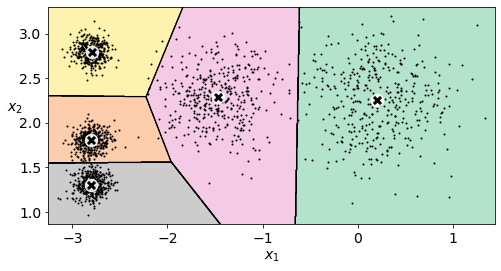

In [13]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

绝大部分的样本都被 clearly 分到正确的 cluster 中了，但也有小部分样本可能分错了（mislabeled），尤其是左上角 cluster 和中间 cluster 边界地方的样本。

确实（indeed），**<font color='crimson'>K-Means 算法在簇（blob）的直径（diameter）非常不同时表现得不是很好（does not behave very well when blobs have very different diameters），这是因为 K-Means 在将一个样本分配给一个 cluster 时仅关心样本到 cluster 中心（centroid）的距离</font>**。

<br>

将每个样本分到单个 cluster 时，称为**<font color='blue'>硬聚类（hard clustering）</font>** ；给出每个样本到每一个 cluster 的 score 也有很用，这称为 **<font color='blue'>软聚类（soft clustering）</font>**。

这个 score 可以是样本到质心（centroid）的距离；也可以是相似度 score（或亲密度 affinity），如高斯径向基函数（Gaussian Radial Basis Function, RBF）。

`KMeans` 中的 `transform()` 方法可以度量每一个样本到每一个 centroid 的距离：

In [14]:
# Transform X to a cluster-distance space.
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

In [15]:
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

`X_new` 中的第一个样本

- 与第一个 centroid 的距离是 2.89

- 与第二个 centroid 的距离是 0.33（最小，所以标签是 1）

- 与第三个 centroid 的距离是 2.90

- 与第四个 centroid 的距离是 1.49

- 与第五个 centroid 的距离是 2.81

如果你的数据集是高维的（high-dimensional），并且使用这种方法来转换（transform）数据集，那么就可以得到一个 k 维的数据集——这种变换（transformation）是**<font color='crimson'>一个非常有效的非线性降维技术</font>**。

## 1.1 K-Means 算法

KMeans 算法将数据集分成 k 个不相交的（disjoint）簇（cluster, C），每个 cluster 用该 cluster 中的样本均值（$\mu_j$）来表示。这些平均值（means）通常称为 cluster 的质心（**centroids**）——通常不是数据集中的点。

KMeans 算法的**<font color='crimson'>目标</font>**是选择使得 **<font color='blue'>inertia</font>** 或者 **within-cluster sum-of-squares criterion** 最小的 centroids

$$\sum^n_{i=0}min_{\mu_j\in C}(||x_i - u_j||^2)$$

可以认为 **inertia** 是用来衡量 cluster 内部的聚集程度（internally coherent），有以下**<font color='crimson'>缺点（drawbacks）</font>**：

- **inertia 假设簇是凸形的（convex）且是各向同质的（isotropic）**，但实际并不总是这样。在 elongated clusters 或者 manifolds with irregular shapes 上表现较差。 [例子](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html)


- **inertia 不是一个标准化的指标（normalized metric）**——值越小越好，0是最优的。但在高维空间中，欧氏距离会变得 inflated（即维度灾难）。在 KMeans 之前运行降维算法（如 [PCA](https://scikit-learn.org/stable/modules/decomposition.html#pca)）可以缓解（alleviate）这个问题和加快计算。

- 知道所有 centroid 的时候，将每个样本分配到距离最近的 centroid 所属的 cluster。

- 知道所有样本的标签（属于每个 cluster 的 index）的时候，通过计算每个 cluster 中样本的平均值来得到该 cluster 的 centroid。

- 都不知道的话，从随机选择 centroids 开始（如，随机选择 k 个样本作为 centroids），然后对样本打标，更新 centroids，对样本打标，更新 centroids ... 直到所有的 centroids 不再移动为止。这个算法保证在有限的步骤内（通常很小）收敛（converge in a finite number of steps），并且不再震荡（oscillate）。

**【原始的 K-Means 算法】：**

- 初始化时随机选择 k 个 centroids —— 在数据集中随机选择 k 个样本，并且 centroids 就是对应的样本位置


- 重复以下步骤直到收敛（即，centroids 不再移动。但在实际中，如果连续两次迭代的 centroids 误差很小的话即可，见参数 `tol`）：

  - 将每一个样本分到最近的 centroid
  
  - 通过计算分到该 centroid 的所有样本的平均值来更新 centroid


`KMeans` 默认使用最优的算法。如果想用**【原始的 K-Means 算法】**（for educational purposes only），必须设置 `init='random'`、`n_init=1` 和 `algorithm='full'`。

通过一个例子看看【原始的 K-Means 算法】是如何运行的：

In [16]:
# max_iter：运行一次时，最大的迭代次数
kmeans_iter_1 = KMeans(n_clusters=5, init='random', n_init=1, algorithm='full',
                       max_iter=1, random_state=1)
kmeans_iter_2 = KMeans(n_clusters=5, init='random', n_init=1, algorithm='full',
                       max_iter=2, random_state=1)
kmeans_iter_3 = KMeans(n_clusters=5, init='random', n_init=1, algorithm='full',
                       max_iter=3, random_state=1)

kmeans_iter_1.fit(X)
kmeans_iter_2.fit(X)
kmeans_iter_3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=1, n_jobs='deprecated', precompute_distances='deprecated',
       random_state=1, tol=0.0001, verbose=0)

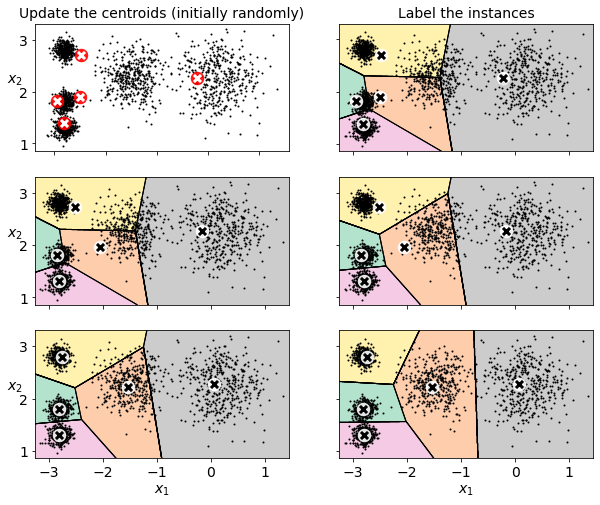

In [17]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter_1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel('$x_2$', fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter_1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter_1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter_2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter_2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter_2, X, show_centroids=False)
plot_centroids(kmeans_iter_3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter_3, X, show_ylabels=False)

plt.show()

可以看到，centroids 初始时时随机的（左上），然后对样本进行打标（右上）；然后更新 centroids（左中），重新对样本打标（右中）...。可以看到 3 次迭代（iterations），算法已经得到一个接近最优的 clustering 了。

<div class="alert alert-block alert-info">
    <b>该算法（原始的 K-Means 算法）的计算复杂度（computational complexity）通常与样本数（m）、cluster 的数量（k）和样本维度（n）呈线性关系。</b>但，这仅当数据具有聚类结构（clustering structure）时才这样。如果不是的话，那么在最坏的情况下（in the worst-case scenario），随着样本数量增加复杂度会呈指数增加（increase exponentially）。实际上，这种情况很少发生，并且 K-Means 通常是最快的聚类算法之一。
</div>

**尽管（在时间足够时）算法保证能够收敛（converge），但是可能不会收敛到正确解（也就是收敛到局部最优）——这取决于中心点的初始化（centroid initialization）。**

In [18]:
kmeans_rnd_init_1 = KMeans(n_clusters=5, init='random',
                           n_init=1, algorithm='full',
                           random_state=11)
kmeans_rnd_init_2 = KMeans(n_clusters=5, init='random',
                           n_init=1, algorithm='full',
                           random_state=19)

kmeans_rnd_init_1.fit(X)
kmeans_rnd_init_2.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=1, n_jobs='deprecated', precompute_distances='deprecated',
       random_state=19, tol=0.0001, verbose=0)

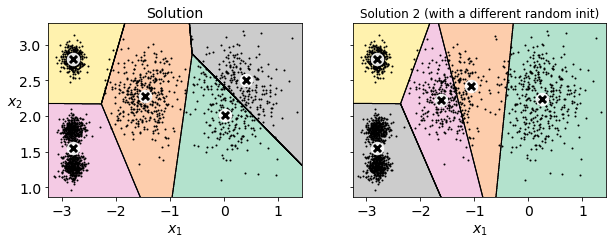

In [19]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_rnd_init_1, X)
plt.title('Solution', fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_rnd_init_2, X, show_ylabels=False)
plt.title('Solution 2 (with a different random init)')

plt.show()

看看有哪些方法能解决中心点随机初始化的问题。

## 1.2 中心点初始化方法（Centroid initialization methods）

### 1.2.1 事先知道 centroids 的大概位置

如果事先知道 centroids 的大概位置（可能通过其他聚类算法），那么可以将超参数 `init` 设置成包含 centroid 列表的 NumPy 数组，并将 `n_init` 设置成 1。

```python
# shape: (n_clusters, n_features)
good_inits = np.array([
    [-3, 3],
    [-3, 2],
    [-3, 1],
    [-1, 2],
    [0, 2]
])
kmeans = KMeans(n_clusters=5, init=good_inits, n_init=1,
                algorithm='full', random_state=42)
```

### 1.2.2 用不同的随机初始化来多次运行算法

使用不同的随机初始化来多次运行算法，并保留最优解。（Run the algorithm multiple times with different random initializations and keep the best solution）

随机初始化的次数由超参数 `n_init` 控制，默认为 10 —— 意味着，在调用 `fit()` 方法的时候，算法会运行 10 次，然后保留最优解。

但，**怎样判断是不是最优解呢？** 使用性能指标（performance metric），这个指标称之为模型的 **<font color='blue'>inertia</font>**，即每个样本与其最近 centroid 的均方距离（mean square distance）。

In [20]:
# 上图左侧和右侧算法的 inertia
kmeans_rnd_init_1.inertia_, kmeans_rnd_init_2.inertia_

(223.29108572819047, 237.46249169442862)

`KMeans` 会运行 `n_init` 次算法，并保留 inertia 最低的模型。

本例中，最低的 inertia 是：

In [21]:
# 获取模型的 inertia
# Sum of squared distances of samples to their closest cluster center.
kmeans.inertia_

211.59853725816828

**`score()` 返回 inertia 的负数。**

> 因为 predictor 的 `score()` 方法遵循 **<font color='crimson'>Scikit-Learn 的“越大越好”（greater is better）规则</font>** —— 一个 predictor 比另一个 predictor 好的话，其 `score()` 方法应该返回一个更大的 score。

In [22]:
# Opposite of the value of X on the K-means objective.
kmeans.score(X)

-211.59853725816828

### 1.2.3 K-Means++

[paper, 2006](https://homl.info/37) 中的 K-Means++ 是一个重要的改进，引入了一种更加智能的初始化步骤（initialization step）。该步骤**倾向于选择彼此相距较远的 centroids （trends to select centroids that are distant from one another）**，这使得 K-Means 算法不大可能（much less likely）收敛到次优解（suboptimal solution）。

论文表明，更智能的初始化步骤所需的额外计算是值得的，因为这可以大大减少算法找到最优解的运行次数。

**【K-Means++ 算法】原理：**

1. 取（take）一个中心点 centroid —— $\pmb{c}^1$，是在数据集中随机均匀选择得到的（chosen uniformly at random）。

2. 取（take）一个新的中心点 centroid —— $\pmb{c}^i$，选择一个概率为 $D(\pmb{x}^i)^2/\sum_{j=1}^{m}D(\pmb{x}^j)^2$ 的样本 $\pmb{x}^i$，其中 $D(\pmb{x}^i)$ 是样本 $\pmb{x}^i$ 与当前已有中心点（centroid）的最短距离（即与最近一个 centroid 的距离）。这种概率分布（probability distribution）确保距离当前已有中心点较远的样本有更大的可能被选为 centroids。

3. 重复上一步骤，直到选择了 k 个 centroids。

`KMeans` 默认使用这种方法。

In [23]:
with sklearn.config_context(print_changed_only=True):
    print(KMeans())

KMeans()


In [24]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs='deprecated',
       precompute_distances='deprecated', random_state=None, tol=0.0001,
       verbose=0)

In [25]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581683

**KMeans++ 算法可以单独用来为其他聚类算法寻找初始的种子（seeds）**，见[`sklearn.cluster.kmeans_plusplus()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.kmeans_plusplus.html#sklearn.cluster.kmeans_plusplus)。

In [26]:
from sklearn.cluster import kmeans_plusplus


centers, indices = kmeans_plusplus(X, n_clusters=5, random_state=42)
centers.shape, indices.shape

((5, 2), (5,))

In [27]:
# The inital centers for k-means.
centers

array([[-1.64045267,  2.40167148],
       [-2.6770888 ,  1.42472409],
       [ 0.33278969,  2.59401063],
       [-2.73217371,  2.76558947],
       [ 0.35629072,  1.72351701]])

In [28]:
# The index location of the chosen centers in the data array X.
# For a given index and center, X[index] = center.
indices

array([1126,  356, 1182,  305,   88])

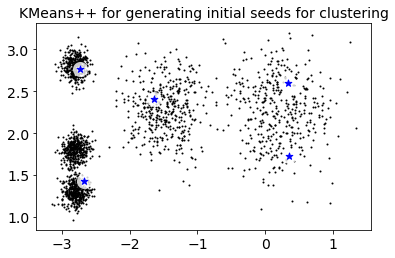

In [29]:
plt.figure(figsize=(6, 3.8))
plot_data(X)
plt.scatter(centers[:, 0], centers[:, 1], marker='o', c='w',
            lw=8, s=50, zorder=10, alpha=0.8)
plt.scatter(centers[:, 0], centers[:, 1], marker='*', c='blue',
            s=50, lw=1, zorder=20, alpha=1)
plt.title("KMeans++ for generating initial seeds for clustering", fontsize=14)
plt.show()

## 1.3 加速的 K-Means 和 Mini-Batch K-Means

### 1.3.1 Accelerated K-Means

[Charles Elkan, 2003](https://homl.info/38) 是 K-Means 的另一个重要改进 —— **<font color='crimson'>避免了许多不必要的距离计算</font>（unnecessary distance calculations）**，大大地（considerably）加速了算法。Elkan 利用三角不等式（triangle inequality）（直线是两点之间的直线距离；即，A、B、C三点之间的距离关系总是满足 AC ≤ AB + BC）和跟踪（keep track）样本与 centroids 之间距离的上下限来实现了这一点。

在 `KMeans` 中设置 **`algorithm='elkan'`** 即可使用这一算法。注意，该算法不支持稀疏数据（sparse data），所以，Scikit-Learn 默认对 dense data 使用 `'elkan'`，对 sparse data 使用 `'full'`。

In [30]:
%timeit -n 50 KMeans(algorithm='elkan').fit(X)

94.4 ms ± 5.9 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [31]:
%timeit -n 50 KMeans(algorithm='full').fit(X)

85.2 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### 1.3.2 Mini-Batch K-Means

[David Sculley, 2010](https://homl.info/39) 提出了 K-Means 算法的另一个重要变体（important variant）。算法能够在每次迭代中使用小批量（mini-batches）数据来稍微（just slightly）移动 centroids，而不是在每次迭代中使用整个数据集。

这通常会使算法的速度提高 3 到 4 倍，并且可以对无法 fit in memory 的大型数据集进行聚类。

<br>

**该算法在以下 2 个主要步骤间迭代（iterate），直到收敛或达到预定的迭代次数。**

- 在数据集中随机抽取部分样本形成 mini-batches，并且将这样本会分配到最近的 centroids 中。


- 更新 centroids。和 K-Means 相反，这一步是在单个样本上完成的。对于 mini-batches 中的每一个样本，centroid 取当前样本和之前分配给该 centroid 的所有样本的 streaming average 来更新。 This has the effect of decreasing the rate of change for a centroid over time. 



In [32]:
from sklearn.cluster import MiniBatchKMeans


minibatch_kmeans = MiniBatchKMeans(
    n_clusters=5,
    batch_size=100,  # default, size of the mini batches
    random_state=42
)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [33]:
minibatch_kmeans.inertia_

211.93186531476786

**<font color='crimson'>如果数据集无法 fit in memory</font>**

- 最简单的方法是使用 **`memmap`** 类；


- 或者数据太大没法用 `memmap` 的话，每次给 `partial_fit()` 传一个 mini-batch。但是这需要更多的工作，因为需要执行多次初始化并选择一个最好的。

In [34]:
from sklearn.datasets import fetch_openml


mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [35]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    mnist['data'], mnist['target'], test_size=0.25, random_state=42)

X_train.shape, y_train.shape

((52500, 784), (52500,))

In [36]:
# 将数据写到 `memmap` 中
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [37]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=19, batch_size=10, random_state=10)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=19, n_init=3, random_state=10,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [39]:
# 在实际中，不需要从 disk 中读取数据集
def load_next_batch(batch_size=100):
    return X[np.random.choice(len(X), batch_size, replace=False)]

In [40]:
np.random.seed(42)

k = 5
n_init = 10
n_iterations = 100  # Maximum number of iterations over the complete dataset 
batch_size = 100    # Size of the mini batches.
init_size = 500
evaluate_on_last_n_iters = 10

best_kmeans = None

# Number of random initializations that are tried.
for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(
        n_clusters=k,
        # Number of samples to randomly sample for speeding up the initialization
        init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None
        or minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [41]:
# Opposite of the value of X on the K-means objective.
best_kmeans.score(X)

-211.70999744411446

**<font color='crimson'>尽管 Mini-batch K-Means 比常用的 K-Means 收敛快，但其 inertia 通常略差一点（slightly worse），尤其是在随着 clusters 的数量增加的时候。</font>**

In [42]:
%timeit KMeans(n_clusters=5).fit(X)

55.5 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

25.7 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
from timeit import timeit

In [48]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))

for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    # 要学会这个哦
    print("\r{}/{}".format(k, 100), end='')
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

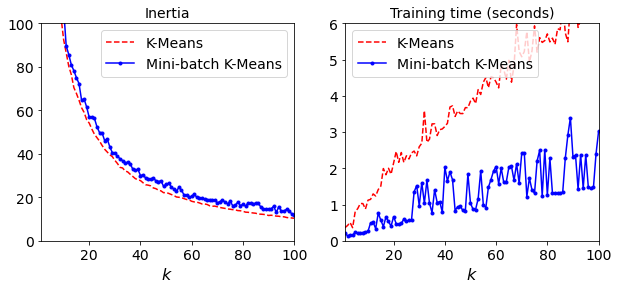

In [49]:
plt.figure(figsize=(10, 3.6))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

左图中，inertia 随着 k 的增加，差异变得越来越大，因为 inertia 变得越来越小。

右图中，Mini-batch K-Means 比 K-Means 快得多，并且差异随着 k 的增加而增加。

## 1.4 寻找最佳的聚类数

如何找到最佳的 cluster 个数并不容易。

**并不是 inertia 越小对应的 k 越好**。因为**<font color='crimson'>随着 k 的 增加，inertia 会不断降低。cluster 越多（k 越大），每个样本越接近其最近的 centroid，因此 inertia 越小</font>**。

In [52]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k5 = KMeans(n_clusters=5, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

kmeans_k3.fit(X)
kmeans_k5.fit(X)
kmeans_k8.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs='deprecated',
       precompute_distances='deprecated', random_state=42, tol=0.0001,
       verbose=0)

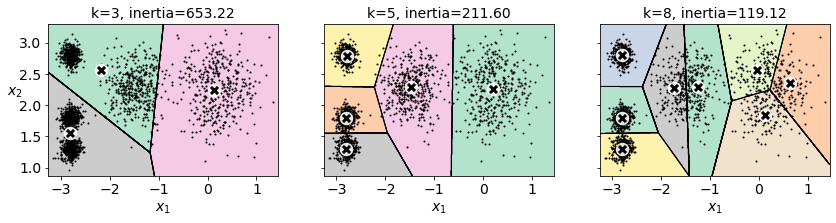

In [58]:
plt.figure(figsize=(14, 2.8))

plt.subplot(131)
plot_decision_boundaries(kmeans_k3, X)
plt.title("k={}, inertia={:.2f}".format(3, kmeans_k3.inertia_), fontsize=14)

plt.subplot(132)
plot_decision_boundaries(kmeans_k5, X, show_ylabels=False)
plt.title("k={}, inertia={:.2f}".format(5, kmeans_k5.inertia_), fontsize=14)

plt.subplot(133)
plot_decision_boundaries(kmeans_k8, X, show_ylabels=False)
plt.title("k={}, inertia={:.2f}".format(8, kmeans_k8.inertia_), fontsize=14)

plt.show()

然后，可以绘制出 inertia 作为 k 的函数，并分析曲线：

In [77]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

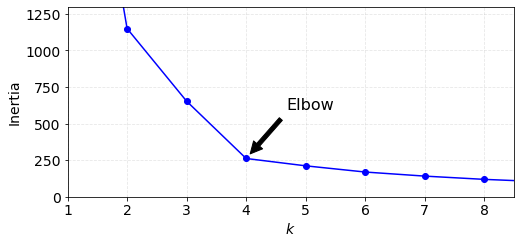

In [78]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.grid(alpha=0.3, ls='--')
plt.show()

可以看到，在 k=4 的时候，inertia 下降的很快，但随着 k 继续增大，inertia 下降得很慢。该曲线大致像一个手臂形状，在 k=4 处有个 elbow（肘）。因此，在不知道更好的选择时，k=4 是一个不错的选择——较低的值变化比较大，而较高的值没什么帮助。

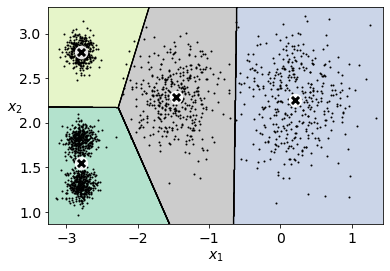

In [79]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

这种方法相当粗糙（rather coarse）。

一种更精确的（precise）方法（也需要更多的计算）是使用**<font color='blue'>轮廓分数（silhouette score）</font>** —— 所有样本的轮廓系数平均值（mean silhouette coefficient over all the instances）。

**<font color='blue'>一个样本的轮廓系数（silhouette coefficient）</font>** 等于 $\frac{b-a}{max(a,b)}$，其中 a 是该样本到 cluster 内其他样本的距离平均值，b 是平均的 nearest-cluster 距离（即，与下一个最近 cluster 内样本的距离平均值）

> - **a**: The mean distance between a sample and all other points in the same class.
> - **b**: The mean distance between a sample and all other points in the next nearest cluster.

轮廓系数（silhouette coefficient）的取值范围是 **[-1, +1]**：

- 接近 **-1** 表示该样本可能分错类（cluster）了；

- 接近 **0** 表示该样本在或者非常接近相邻 2 个 cluster 的边界（boundary）；

- 接近 **+1** 表示该样本在应属于的 cluster 中，并远离其他 cluster。

**轮廓系数（silhouette coefficient）仅当 label 的个数在 [2, n_samples-1] 时有效。**

<br>

silhouette score 的优点：

- 分数的取值在 -1（分错了）和 +1（高度密集聚类）之间，在 0 附近表示重叠的clusters.

- 在 clusters 密集且完全分割（well separated）时，score 越高。这与 cluster 的标准概念（standard concept）相关。

silhouette score 的缺点：

- 相对于其他概念的 clusters，silhouette coefficient 通常在 convex clusters 上的分数更高。

In [71]:
# 可以得到每一个样本的 silhouette coefficient
from sklearn.metrics import silhouette_samples

silhouette_coeffs = silhouette_samples(X, kmeans.labels_)
silhouette_coeffs.shape

(2000,)

In [72]:
silhouette_coeffs

array([0.66694071, 0.73103018, 0.48656361, ..., 0.846275  , 0.70971862,
       0.62920907])

In [73]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

In [75]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

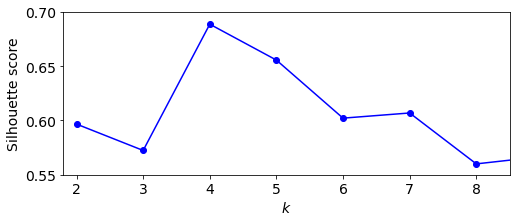

In [76]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

可以看出，k=4 是一个很好的选择，但 k=5 也是可以的，并且比 6/7 好得多。这是在比较 inertia 时没法看到的。

一个可以获得更多信息的可视化是，绘制每个样本的 silhouette coefficient，并按分配到的 cluster 和值的大小来排序。这称为 **<font color='blue'>silhouette diagram</font>**。图中每个 cluster 的形状类似于刀（knife），其**高度**（height）表示该 cluster 中包含的样本数量，其**宽度**（width）表示 cluster 中样本的排序 silhouette coefficient（越宽越好）。**虚线**（dashed line）表示平均 silhouette coefficient。

In [80]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

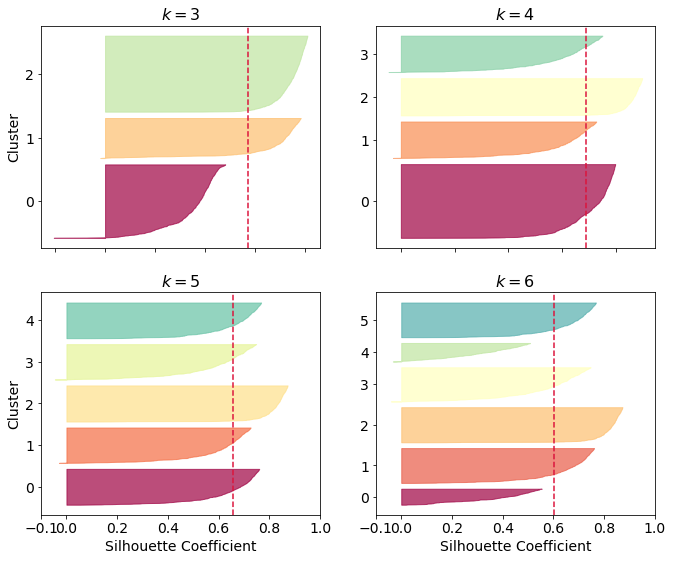

In [85]:
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coeffs = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coeffs[y_pred == i]
        coeffs.sort()
        
        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="crimson", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.show()

图中，垂直的虚线表示 silhouette_score。当 cluster 中大部多数样本的 silhouette coefficient 比这个 score 低的话（即，许多样本短于这个虚线），这个 cluster 是比较差的，因为该 cluster 中大多数样本离其他 cluster 较近。可以看到， k=3/6 时，得到了 bad clusters。但在 k=4/5 时，clusters 看起来不错——绝大多数样本都超多了虚线，并向右延伸，接近 0。在 k=4 的时候，第一个 cluster 相当大。在 k=5 时，所有 clusters 大小差不多。所以，尽管 k=4 的 score 更高比 k=5 略高，但使用 k=5 能获得大小相似的 cluster。

## 1.5 K-Means 的局限性

尽管有许多有点（merits），尤其是 fast 和 scalable，但是 K-Means 并不是完美的（perfect）。

- 需要多次运行算法以避免局部最优（suboptimal solutions）


- 需要指定 cluster 的个数，这很麻烦（is quite a hassle）


- 当 cluster 的大小不同、密度不同，或形状非球形时，K-Means 表现都不好

例子：数据集包含 3 个不同维度、不同密度、不同方向（orientation）的椭圆形 cluster 时，K-Means 的表现。

In [86]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

X.shape, y.shape

((1250, 2), (1250,))

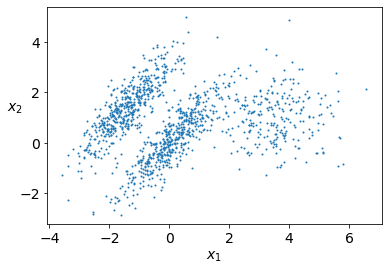

In [87]:
plot_clusters(X)

In [88]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                     n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)

kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs='deprecated',
       precompute_distances='deprecated', random_state=42, tol=0.0001,
       verbose=0)

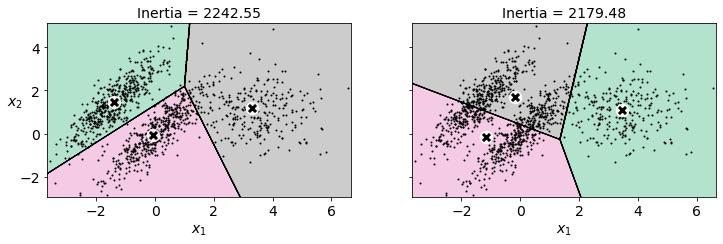

In [91]:
plt.figure(figsize=(12, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.2f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.2f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

可以看到，都不好。虽然左图看起来 better，但是中间 cluster 的 25% 样本仍然分到了最右边的 cluster。右图简直垃圾，虽然 inertia 看起来 lower。

所以，数据不同，不同的聚类算法可能表现更好。

对于椭圆形的（elliptical） cluster，Gaussian mixture model 表现更好。

<div class="alert alert-block alert-info">
    <b>在运行 K-Means 之前，需要 scale 输入数据，否则 clusters 可能会 very stretched，这样 K-Means 表现会很差。</b>虽然，scale 输入数据并不能保证所有的 clusters 都 nice 和 spherical（球形的），但通常会 improve things。
</div>

接下来，看看如何从聚类中 benefit。虽然使用的 K-Means 算法，但可以尝试其他聚类算法。

# 2. 使用聚类进行图像分割

图像分割（image segmentation）是将图像分成多个 segment 的任务。

- **语义分割（semantic segmentation）**：属于相同对象的所有像素（pixels）都会被分成同一个 segment。如无人驾驶（self-driving）的视觉系统（vision system）中，属于行人（pedestrian）的所有像素都分配给“行人”这一 segment，就是一个 segment 会包含所有的行人。


- **实例分割（instance segmentation）**：属于相同单个对象（same individual object）的所有像素都会被分成同一个 segment。如，每个行人属于不同的 segment。

图像分割中的 SOTA 是基于 CNN 的复杂结构。这里，比较简单，只是**颜色分割（color segmentation）** —— 如果像素具有相似的颜色，那么将会被分成相同的 segment。如，分析卫星图片（satellite image）中测量某个区域的森林面积，颜色分割就够了。

In [92]:
# 加载图片
from matplotlib.image import imread

image = imread('ladybug.png')
image.shape

(533, 800, 3)

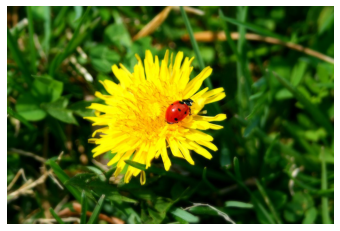

In [107]:
plt.imshow(image)
plt.axis('off')
plt.show()

图片被表示成 3D 数组

- 第一个维度的大小是高度（height）

- 第二个维度的大小是宽度（width）

- 第三个维度的大小是颜色通道（color channel）（这里是 RGB）的数量

即，对于每个像素（pixel）都有一个 3D 向量——包含红、绿、蓝的强度（intensities）——范围在 0 到 1 之间（或，0 到 255 之间，如果使用 `imageio.imread()` 的话）。

但，灰度图像（grayscale images）只有一个 channel。某些图片可能有更多的 channels，如含有一个用于透明度（transparency）的 alpha channel 的图像或卫星图像——通常包含许多表示 light frequencies（如，红外infrared）的 channels。

In [95]:
# Reshape the array to get a long list of RGB colors
X = image.reshape(-1, 3)
X.shape

(426400, 3)

In [96]:
arr = np.arange(12).reshape(2, 2, 3)
arr

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

In [97]:
arr.reshape(-1, 3)

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [112]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [113]:
# Labels of each point.
# shape: (426400,)
kmeans.labels_

array([1, 1, 1, ..., 4, 1, 1], dtype=int32)

In [114]:
# Coordinates of cluster centers
# shape: (8, 3)
kmeans.cluster_centers_

array([[0.98355126, 0.93589437, 0.02574921],
       [0.02289104, 0.11075309, 0.00578403],
       [0.21914515, 0.3867588 , 0.05800817],
       [0.75767887, 0.2122915 , 0.04460664],
       [0.09996888, 0.2542923 , 0.01695383],
       [0.61266285, 0.63010097, 0.3875053 ],
       [0.37211835, 0.5236006 , 0.1573076 ],
       [0.8845953 , 0.725588  , 0.03441758]], dtype=float32)

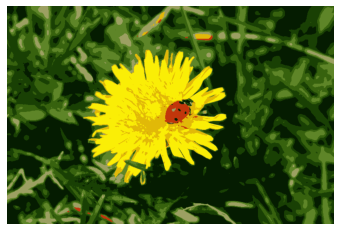

In [116]:
# 使用 KMeans(n_cluters=8) 聚类之后的图片
plt.imshow(segmented_img)
plt.axis('off')
plt.show()

In [105]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

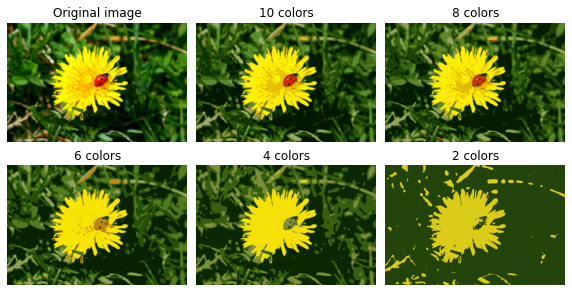

In [118]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

可以看到，当 cluster 的个数少于 8 个时，瓢虫（ladybug）的亮红色（flashy red color）没法单独成一个 cluster 了，将会环境颜色合并。这是因为 **K-Means 更喜欢大小差不多的 cluster**。瓢虫很小，比图片的其余部分小得多，所以即时颜色闪亮（flashy），K-Means 也不能为其单独指定一个 cluster。

# 3. 使用聚类进行数据预处理（Using clustering for Preprocessing）

聚类是在监督学习算法之前的一种有效预处理步骤。

In [119]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_digits.shape, y_digits.shape

((1797, 64), (1797,))

In [120]:
y_digits

array([0, 1, 2, ..., 8, 9, 8])

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((1347, 64), (450, 64))

In [125]:
# 训练一个基准模型
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs',
                             max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

log_reg.score(X_test, y_test)

0.9688888888888889

**这里，为什么使用 50 而不是 10（类别数），这是因为每种数字可以有多个写法，因此最好使用更大的 clusters 个数。**

In [126]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50, random_state=42)),
    ('log_reg', LogisticRegression(multi_class='ovr', solver='lbfgs',
                                   max_iter=5000, random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10,
                        n_jobs='deprecated', precompute_distances='deprecated',
                        random_state=42, tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [127]:
pipeline.score(X_test, y_test)

0.9777777777777777

In [128]:
# 错误率从 3.1% 降到了 2.2%，错误率约降低 28.57%
1 - (1 - 0.9777777777777777) / (1 - 0.9688888888888889)

0.28571428571428414

这里，可以将聚类的 cluster 个数作为超参数。

In [132]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs='deprecated',
                                               precompute_distances='deprecated',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
        

In [133]:
grid_clf.best_params_

{'kmeans__n_clusters': 95}

In [134]:
grid_clf.score(X_test, y_test)

0.9777777777777777

**`n_jobs=-1` 会损失精度。**

In [135]:
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=99, random_state=42)),
    ('log_reg', LogisticRegression(multi_class='ovr', solver='lbfgs',
                                   max_iter=5000, random_state=42))
])
pipeline.fit(X_train, y_train)

pipeline.score(X_test, y_test)

0.98

# 4. 使用聚类进行半监督学习

当只有部分打标样本，且还有很多未打标的样本时，可以考虑使用聚类。

In [136]:
# 假设只有 50 个打标样本
n_labeled = 50

In [137]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

此时精度只有 83.33%，比在完整训练集上要差多了。

怎样做的更好呢？

**<font color='crimson'>方法 1：</font>**

首先，将训练集聚类为 50 个 cluster，然后，对于每个 cluster，找到最接近 centroid 的图像——称之为 **representative images**：

In [143]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
# 每个样本到 centroid 的距离
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]
X_representative_digits.shape

(50, 64)

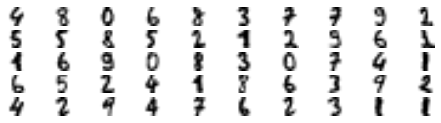

In [145]:
# representative images
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8),
               cmap='binary', interpolation='bilinear')
    plt.axis('off')

plt.show()

In [146]:
# 手动对这些图片打标
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

在这些 representative images 上看看性能：

In [147]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000,
                             random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

准确性从 83.33% 提升到 92.2% 了。所以，仅仅标记 representative instances 是一个好主意。

**<font color='crimson'>方法 2：</font>**

看看将 label 扩散到（propagate）cluster 中的所有样本（称之为 **<font color='blue'>label propagation</font>**） 之后的效果：

In [148]:
# Label propagation
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):  # k = 50
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [149]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000,
                             random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9333333333333333

效果又提升了。

**<font color='crimson'>方法 3：</font>**

但在 label propagation 时，cluster 中的边缘样本（靠近边界）很可能会被错误标记。可以考虑仅将标签扩散到离 centroids 最近的 20% 样本。

In [157]:
percentile_closest = 20

# 每个样本到其所属 cluster 的 centroid 的距离
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):  # k = 50
    in_cluster = (kmeans.labels_ == i)
    # 该 cluster 内所有样本到 centroid 的距离
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_dist = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_dist)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [158]:
X_train_partially_propagated.shape, y_train_partially_propagated.shape

((291, 64), (291,))

In [159]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000,
                             random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.94

之所以能达到这样的效果，是因为 label propagation 的效果好，准确率非常高。

In [160]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896907216494846

<div class="alert alert-block alert-info">
    <center><b>主动学习（Activate Learning）</b></center>
    <br>
    为了继续提升模型和改进训练集，下一步可能需要进行几轮主动学习，即在人类与算法进行交互时，提供算法要求的特定样本的标签。
    <br>
主动学习有不同的策略，但常用的是<b>不确定性采样（uncertainty sampling）</b>，步骤如下：
    
1. 模型是在目前能收集到标签的样本上训练的，并且用该模型对所有未打标样本进行预测；
2. 把模型最不确定的（most uncertain）样本（即，估计的概率最低）交给专家来打标；
3. 重复此过程，直到性能改进到不值得打标为止。

<br>
其他的策略包括

1. 打标那些导致模型变化最大（largest model change）的样本；
2. 或，打标那些会使在验证集上错误下降最大（the largest drop in the model's validation error）的样本；
3. 或，打标那些不同模型结果不一致的样本。
</div>

# 5. DBCSAN

# 6. 其他聚类算法